<a href="https://colab.research.google.com/github/OnurKerimoglu/Colab_Notebooks/blob/master/DSR_NLP6_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers tokenizers datasets
import tensorflow as tf
import glob
import os
import shutil
import tqdm
import random
import matplotlib.pyplot as plt
import torch
#following are all from huggingface
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer

tf.config.list_physical_devices("GPU")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 15.1 MB/s 
     |████████████████████████████████| 7.6 MB 50.0 MB/s 
     |████████████████████████████████| 441 kB 43.9 MB/s 
     |████████████████████████████████| 163 kB 74.6 MB/s 
     |████████████████████████████████| 115 kB 72.8 MB/s 
     |████████████████████████████████| 212 kB 70.9 MB/s 
     |████████████████████████████████| 127 kB 18.2 MB/s 
     |████████████████████████████████| 115 kB 61.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
dataset_file = "dataset.txt"

# How many files to load.
file_number = 100

# Clone the repo.
!git clone https://github.com/vilmibm/lovecraftcorpus
    
# Find all the files.
paths = glob.glob("lovecraftcorpus/*.txt")

# Do not use all.
paths = paths[:file_number]
print(sorted(paths))

# Merge.
with open(dataset_file, "w") as output_file:
    for path in paths:
        for line in open(path, "r"):
            for split in line.split("\n"):
                split = split.strip()
                if split != "":
                    print(split, file=output_file)

# Delete repo.
!rm -rf lovecraftcorpus

# Done.
print("Corpus downloaded.")

Cloning into 'lovecraftcorpus'...
remote: Enumerating objects: 70, done.
remote: Total 70 (delta 0), reused 0 (delta 0), pack-reused 70
Unpacking objects: 100% (70/70), done.
['lovecraftcorpus/alchemist.txt', 'lovecraftcorpus/arthur_jermyn.txt', 'lovecraftcorpus/azathoth.txt', 'lovecraftcorpus/beast.txt', 'lovecraftcorpus/beyond_wall_of_sleep.txt', 'lovecraftcorpus/book.txt', 'lovecraftcorpus/celephais.txt', 'lovecraftcorpus/charles_dexter_ward.txt', 'lovecraftcorpus/clergyman.txt', 'lovecraftcorpus/colour_out_of_space.txt', 'lovecraftcorpus/cool_air.txt', 'lovecraftcorpus/crawling_chaos.txt', 'lovecraftcorpus/cthulhu.txt', 'lovecraftcorpus/dagon.txt', 'lovecraftcorpus/descendent.txt', 'lovecraftcorpus/doorstep.txt', 'lovecraftcorpus/dreams_in_the_witch.txt', 'lovecraftcorpus/dunwich.txt', 'lovecraftcorpus/erich_zann.txt', 'lovecraftcorpus/ex_oblivione.txt', 'lovecraftcorpus/festival.txt', 'lovecraftcorpus/from_beyond.txt', 'lovecraftcorpus/gates_of_silver_key.txt', 'lovecraftcorpus/ha

In [ ]:
raw_datasets = load_dataset("text", data_files=[dataset_file]) #from hugging face datasets
raw_datasets

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-cf255201966ee4e3/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4371
    })
})

In [ ]:
for index in range(10):
  token_sequence = raw_datasets["train"][index]["text"]
  print(token_sequence)

AT THE MOUNTAINS OF MADNESS
I
I am forced into speech because men of science have refused to follow my advice without knowing why. It is altogether against my will that I tell my reasons for opposing this contemplated invasion of the antarctic--with its vast fossil hunt and its wholesale boring and melting of the ancient ice caps. And I am the more reluctant because my warning may be in vain.
Doubt of the real facts, as I must reveal them, is inevitable; yet, if I suppressed what will seem extravagant and incredible, there would be nothing left. The hitherto withheld photographs, both ordinary and aerial, will count in my favor, for they are damnably vivid and graphic. Still, they will be doubted because of the great lengths to which clever fakery can be carried. The ink drawings, of course, will be jeered at as obvious impostures, notwithstanding a strangeness of technique which art experts ought to remark and puzzle over.
In the end I must rely on the judgment and standing of the few

In [ ]:
tokenizer = Tokenizer(BPE(unk_token="[UNK]")) #Byte pair encoding
trainer = BpeTrainer(vocab_size=5000,special_tokens=["[UNK]","[PAD]"])
tokenizer.pre_tokenizer = Whitespace()

# this is a generator: instead of putting a function inside a loop, 
# we put the loop inside the function
def batch_iterator(batch_size=1000):
  for i in range(0,len(raw_datasets["train"]),batch_size):
    yield raw_datasets["train"][i:i+batch_size]["text"] #yield doesn't terminate the function, unlike a return

tokenizer.train_from_iterator(
    batch_iterator(),
    trainer=trainer, 
    length=len(raw_datasets["train"])
)
tokenizer.save("tokenizer.json")
tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")
tokenizer.add_special_tokens({"pad_token":"[PAD]"})

0

In [ ]:
print(tokenizer.vocab_size)
print(tokenizer.vocab)

5000
{'pallid': 4956, 'yield': 4156, 'ow': 136, 'floated': 3590, 'utes': 3009, '>': 25, 'painted': 3524, 'ts': 310, 'animal': 1950, 'shr': 2844, 'empt': 2149, 'actual': 2023, 'pengu': 4223, 'extent': 3459, 'ude': 988, 'hole': 3383, 'waning': 4951, 'stock': 4304, 'ied': 505, 'ishing': 3213, 'shudder': 2650, 'echo': 2338, 'report': 3917, 'fallen': 2244, 'aspect': 2039, 'look': 444, 'power': 1655, ':': 23, 'impressions': 2785, 'bi': 3944, 'sky': 986, 'advent': 3643, 'thetic': 3963, 'disliked': 4887, 'wr': 1370, 'sur': 509, 'leave': 1848, 'waste': 2585, 'sive': 4714, 'experience': 2331, 'ined': 767, 'voy': 4196, ',"': 2415, 'clust': 3330, 'hideous': 725, 'meant': 2467, 'cup': 2579, 'school': 3305, 'Yad': 4825, 'gram': 4502, 'fe': 176, 'My': 875, 'consciousness': 1753, 'yard': 2057, 'Hathe': 4569, 'related': 3914, 'four': 1167, 'bre': 864, 'existed': 3069, 'pho': 1427, 'enath': 2587, 'serious': 4413, 'dazed': 3711, 'went': 726, 'ving': 699, 'fore': 300, 'ciph': 2900, 'caves': 4983, 'his': 1

In [ ]:
token_sequence = raw_datasets["train"][3]["text"]
print(token_sequence)

token_indices = tokenizer(token_sequence)["input_ids"]

print(token_indices)

tokens = [tokenizer.decode([index]) for index in token_indices]
print(tokens)

Doubt of the real facts, as I must reveal them, is inevitable; yet, if I suppressed what will seem extravagant and incredible, there would be nothing left. The hitherto withheld photographs, both ordinary and aerial, will count in my favor, for they are damnably vivid and graphic. Still, they will be doubted because of the great lengths to which clever fakery can be carried. The ink drawings, of course, will be jeered at as obvious impostures, notwithstanding a strangeness of technique which art experts ought to remark and puzzle over.
[4971, 54, 72, 103, 93, 574, 4427, 9, 109, 35, 394, 3462, 301, 9, 114, 92, 244, 1961, 24, 601, 9, 238, 35, 1125, 1900, 291, 586, 314, 4435, 210, 102, 2449, 9, 267, 278, 122, 697, 627, 11, 184, 4127, 152, 835, 3077, 71, 9, 880, 2612, 102, 4701, 525, 9, 586, 606, 72, 92, 179, 3136, 105, 9, 148, 236, 240, 2610, 605, 2941, 102, 1624, 119, 11, 4700, 9, 236, 586, 122, 2982, 753, 103, 93, 348, 1503, 784, 111, 182, 511, 142, 58, 255, 1449, 424, 122, 2602, 11, 18

100%|██████████| 4371/4371 [00:01<00:00, 2241.46it/s]


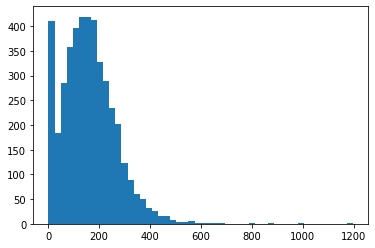

In [ ]:
#let's try to determine the sequence_length based on the 
#typical sequence lengths (i.e., number of tokens for each paragraph)
lengths = []
for token_sequence in tqdm.tqdm(raw_datasets["train"]):
  token_sequence = token_sequence["text"]
  token_indices = tokenizer(token_sequence)["input_ids"]
  lengths += [len(token_indices)]

plt.hist(lengths,bins=50)
plt.show()

#250 might be a good compromise: there will be paragraphs that will be truncated,
#but we will end with a small enough sequence length, which willl be fast to train

In [ ]:
sequence_length = 256
def tokenize_function(example):
  tokenized_example = tokenizer(
      example["text"],
      truncation = True,
      padding = False,
      #padding= "max_length", #we don't have to do this, as while setting up the model, there is an option to do the padding according to the max_length within the batch
      max_length = sequence_length
  )
  return{
      "input_ids": tokenized_example["input_ids"]
  }
token_sequence = raw_datasets["train"][0]
print(token_sequence)

tokenized = tokenize_function(token_sequence)
print(tokenized)

{'text': 'AT THE MOUNTAINS OF MADNESS'}
{'input_ids': [4240, 2285, 39, 41, 47, 40, 46, 27, 35, 40, 45, 41, 32, 39, 27, 30, 40, 31, 45, 45]}


In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_function, 
    batched =True, 
    remove_columns=raw_datasets["train"].column_names
    )

tokenized =tokenized_datasets["train"][0]
print(tokenized)

  0%|          | 0/5 [00:00<?, ?ba/s]

{'input_ids': [4240, 2285, 39, 41, 47, 40, 46, 27, 35, 40, 45, 41, 32, 39, 27, 30, 40, 31, 45, 45]}


In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm = False)

In [ ]:
model_config = GPT2Config(
    vocab_size = tokenizer.vocab_size,
    pad_token_id = tokenizer.pad_token_id,
    n_ctx = sequence_length,
    n_positions = sequence_length,
    n_head = 8, #attention head (i.e. h in attention is all you need paper)
    n_layer = 9, #how many blocks will be stacked (i.e., Nx in the paper)
    n_embd=512 #ie. embedding size
)
model = GPT2LMHeadModel(model_config)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(5000, 512)
    (wpe): Embedding(256, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropo

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids: tensor([[  35,  138, 2504,  351, 1832,  753,  397,  103, 4618,  233, 4551,  111,
          856,  179, 1544,  402,  687, 3900, 1362,   11,  288,  114, 2798,  894,
          179,  586,  128,   35,  628,  179, 4780,  148,  284,  216,  554,  256,
          192,  650,  206,  373, 2927,  109,  135,  103,   93, 2971,  159,  152,
          282,  783,  230,  316,  189,   60, 1089,  102,  282,  809,  110, 2014,
         3822,  102,  167,   64,  489,  103,   93,  649,  402,  855,   71,   11,
          478,   35,  138,   93,  305, 3339,  210,  753,  179, 3751,  802,  122,
           92, 2393,   11]])

logits: tensor([[[-0.0069,  0.7072,  0.5884,  ..., -0.2160,  0.1177,  0.4332],
         [-0.3227,  0.7420,  0.2540,  ..., -0.6130,  0.5638, -0.4559],
         [ 0.5592,  0.7776,  0.1252,  ..., -0.5852, -0.0745,  0.2718],
         ...,
         [ 0.4723,  1.1928, -0.0360,  ..., -0.3559, -0.3707, -0.2806],
         [-0.0808,  0.8550,  0.2281,  ...,  0.9744,  0.0030,  0.6416],
         [ 0.18

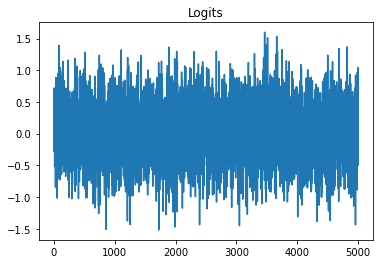

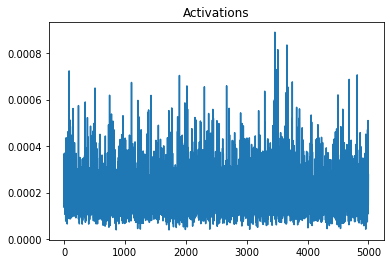

In [ ]:
#For now, the untrained model should make random predictions.
#After training this should change
#Let's see this (randomness) on an example token:
inputs = [tokenized_datasets["train"][2]]
inputs = data_collator(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs)
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()

In [ ]:
training_args = TrainingArguments(
    output_dir = "model",
    overwrite_output_dir = True,
    num_train_epochs = 10,
    per_device_train_batch_size = 8, #per device = per gpu
    prediction_loss_only = False
)

trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = tokenized_datasets["train"]
)

trainer.train()
tokenizer.save_pretrained("model")
model.save_pretrained("model")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4371
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5470


Step,Training Loss
500,6.478000
1000,5.966000
1500,5.749600
2000,5.580200
2500,5.449000
3000,5.336300
3500,5.249900
4000,5.171800
4500,5.115700
5000,5.061600


Saving model checkpoint to model/checkpoint-500
Configuration saved in model/checkpoint-500/config.json
Model weights saved in model/checkpoint-500/pytorch_model.bin
Saving model checkpoint to model/checkpoint-1000
Configuration saved in model/checkpoint-1000/config.json
Model weights saved in model/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to model/checkpoint-1500
Configuration saved in model/checkpoint-1500/config.json
Model weights saved in model/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to model/checkpoint-2000
Configuration saved in model/checkpoint-2000/config.json
Model weights saved in model/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to model/checkpoint-2500
Configuration saved in model/checkpoint-2500/config.json
Model weights saved in model/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to model/checkpoint-3000
Configuration saved in model/checkpoint-3000/config.json
Model weights saved in model/checkpoint-3000/pytorch

In [ ]:
# Encode the conditioning tokens.
input_ids = tokenizer.encode("The most merciful thing in the world, I think, is the inability of the human mind to correlate all its contents.", return_tensors="pt").cuda()
print(input_ids)

# Generate more tokens.
generated_ids = model.generate(
    input_ids,
    max_length=100,
    do_sample=True,
    temperature=1.0
)
generated_sequence = tokenizer.decode(generated_ids[0])
print(generated_sequence)

tensor([[ 184,  325, 3454,  205,   92,   93,  552,    9,   35,  678,    9,  114,
           93,   92, 3974,  103,   93,  577,  609,  111,  421,  695,  227,  156,
          282, 4911,   11]], device='cuda:0')
The most merciful thing in the world, I think, is the in ability of the human mind to cor rel ate all its contents. As I have been so far. My brain of light is very certain -- we realized that the dis pl ative ly and we came it I have been down and the house -- our s down to be almost -- of the city and the man -- we beheld the whole in to our eyes at the unknown thing that we have the dark, and which had been not been
